In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import sys
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(threshold=sys.maxsize)

%matplotlib inline 

In [2]:
train_values = pd.read_csv('data/train_values.csv', index_col='building_id')
train_labels = pd.read_csv('data/train_labels.csv', index_col='building_id')
# train = train_values.merge(train_labels, left_index=True, right_index=True)
# train.sort_index(inplace=True)
train_labels.sort_index(inplace=True)
train_values.sort_index(inplace=True)

In [3]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,30,266,1224,1,25,5,2,t,r,n,f,j,s,d,0,1,0,0,0,0,0,0,0,0,0,v,0,0,0,0,0,0,0,0,0,0,0,0
8,17,409,12182,2,0,13,7,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
12,17,716,7056,2,5,12,6,o,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
16,4,651,105,2,80,5,4,n,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
17,3,1387,3909,5,40,5,10,t,r,n,f,q,o,d,0,0,0,0,1,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [4]:
train_labels.head()

,damage_grade
building_id,
4,2
8,3
12,3
16,2
17,2


## Encode

In [5]:
df_enc = pd.get_dummies(train_values)
df_enc.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,30,266,1224,1,25,5,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
8,17,409,12182,2,0,13,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
12,17,716,7056,2,5,12,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
16,4,651,105,2,80,5,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
17,3,1387,3909,5,40,5,10,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


## SMOTE

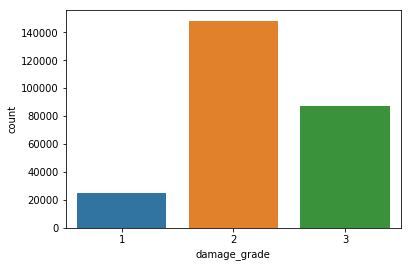

In [6]:
sns.countplot(data=train_labels, x='damage_grade')

In [8]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=42, k_neighbors=5)
x_oversampled, y_oversampled = os.fit_resample(df_enc, train_labels['damage_grade'])

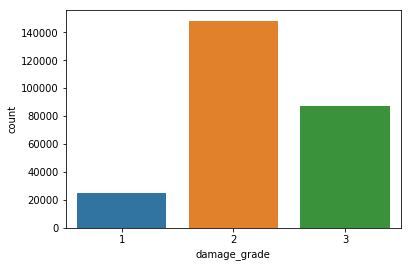

In [9]:
sns.countplot(x=y_oversampled)

# Model

In [34]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [41]:
pipe = make_pipeline(
    MinMaxScaler(), 
    PowerTransformer(standardize=False), 
    xgb.XGBClassifier(objective='multi:softmax', num_class=3, learning_rate=0.1, reg_lambda=0.8, )
)
pipe

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('powertransformer', PowerTransformer(copy=True, method='yeo-johnson', standardize=False)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, ga...      reg_lambda=0.8, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))])

In [ ]:
param_grid={
    'xgbclassifier__max_depth':[12,16,20],
    'xgbclassifier__base_score':[0.45, 0.5, 0.55],
    'xgbclassifier__subsample':[0.8, 1],
    'xgbclassifier__colsample_bytree':[0.8, 1],
    'xgbclassifier__n_estimators':[100, 1000],
    'xgbclassifier__min_child_weight' : [1,3,5]
}
gs = GridSearchCV(pipe, param_grid, cv=3, n_jobs=3, verbose=4)
gs.fit(x_oversampled, y_oversampled)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


In [52]:
gs.best_params_

{'xgbclassifier__base_score': 0.55,
 'xgbclassifier__colsample_bytree': 0.8,
 'xgbclassifier__max_depth': 12,
 'xgbclassifier__min_child_weight': 1,
 'xgbclassifier__n_estimators': 1000,
 'xgbclassifier__subsample': 0.8}

In [53]:
gs.best_score_

0.8148150646278922

# Prediction

In [54]:
test_values = pd.read_csv('data/test_values.csv', index_col='building_id')
test_enc = pd.get_dummies(test_values)
predictions = gs.predict(test_enc)

In [55]:
submission_format = pd.read_csv('data/submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,2
421793,3


In [56]:
my_submission.to_csv('submission-v4.csv')

In [57]:
!head submission-v4.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,2
421793,3
871976,2
691228,1
896100,3
343471,2
